In [3]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.morphology import binary_closing
from skimage.measure import regionprops, label

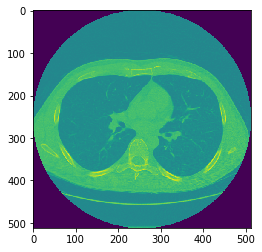

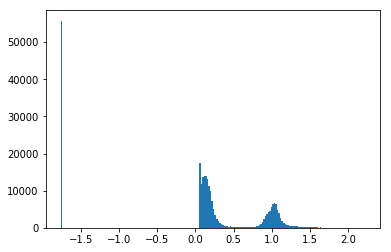

In [7]:
# preprocessing
# goal is to make a mask around lungs

# normalize and get distribution 
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpy_image = sitk.GetArrayFromImage(itkimage) # z, y, x...
    numpy_origin = np.array(itkimage.GetOrigin()) # x, y, z...
    numpy_spacing = np.array(itkimage.GetSpacing())
    return numpy_image, numpy_origin, numpy_spacing

def normalize(numpy_image):
    mean = np.mean(numpy_image)
    std = np.std(numpy_image)
    img = (numpy_image - mean)/std
    return img

def get_normal_slice(img, depth):
    img = img[int(img.shape[0] * depth), 0:512, 0:512]
    return normalize(img)
    
def see_normalize_img(filename):
    img = load_itk_image(filename)[0]
    patch = get_normal_slice(img, 0.5)
    plt.imshow(patch)
#     print(patch[400, 400])
#     print(np.median(patch))
    plt.show()
    plt.hist(patch.flatten(), bins=200)

see_normalize_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
# see_normalize_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')
# see_normalize_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd')

In [ ]:
# since it's bimodal (after adjusting the black border), we could do k-means with k = 2
# we want the black border (in the images where it exists) to match lungs intensity as close as possible
# median is a good estimate based on histograms

def k_means_modified(filename):
    img = load_itk_image(filename)[0]
    img = get_normal_slice(img, 0.5)
    minimum = np.min(img)
    med = np.median(img)
    img[img==minimum] = med # look into Otsu's method over median
    kmeans = KMeans(n_clusters = 2, random_state = 0).fit(img.reshape((-1, 1)))
    centers = kmeans.cluster_centers_.flatten()
    threshold = np.mean(centers)
    img = np.where(img < threshold, 1.0, 0.0)
    plt.imshow(img)
    return img

k_means_modified('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

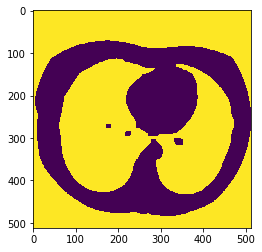

In [5]:
# dilate the lungs (takes max value in a neighborhood of pixels)
def dilate_img(filename):
    img = k_means_modified(filename)
    img = binary_closing(img, selem = np.ones([10, 10]))
    plt.imshow(img)
    return img

dilate_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd')

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

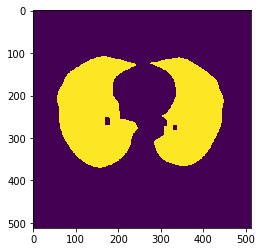

In [6]:
# have to remove the non-lung region
def iso_lungs(filename):
    img = dilate_img(filename)
    # regions are only the ones labelled with ones (bright spots)
    props = regionprops(label(img))
    labels = []
    for p in props:
        B = p.bbox
        if B[0] > 30 and B[2] < 470 and B[1] > 30 and B[3] < 470:
            labels.append(p.label)
    mask = np.zeros((512, 512))
    for l in labels:
        mask = mask + np.where(label(img) == l, 1, 0)
    plt.imshow(mask)
    return mask
    
iso_lungs('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd')

In [ ]:
def apply_mask(filename):
    mask = iso_lungs(filename)
    img, origin, spacing = load_itk_image(filename)
    img = img[int(img.shape[0] * 0.5), 0:512, 0:512]
    img = img * mask
    
    mean = np.mean(img[mask > 0])
    std = np.std(img[mask > 0])
    
    img = (img - mean)/std
    img[mask==0] = -5 # background = mean - 5 * std before normalization, highly unlikely to interfere
    plt.imshow(new_img)
    plt.show()
    plt.hist(new_img.flatten(), bins=200)
    
apply_mask('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd')